In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g23_c05.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g18_c05.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g10_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g18_c04.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g16_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g04_c02.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g25_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g05_c03.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g02_c02.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g12_c03.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g11_c01.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g07_c02.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g06_c05.avi
/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/v_HorseRace_g05_c01.avi
/kaggle/input/ucf101

# Import packages

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping

# Import Label File

In [3]:
label_data = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()

,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [4]:
#Total Number of video folders for classification
len(label_data)

101

# Setting path For data

In [5]:
path=[]
for label in label_data.labels.values:
    path.append('../input/ucf101/UCF101/UCF-101/'+label+"/")
path[0]

'../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/'

# Data Preperation

In [6]:
#Function for Feature Extraction
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=5
    frames_list=[]
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        if not ret:
            break;
        #Resize the image
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        #Append to the frame
        frames_list.append(frame)
    video_reader.release()
    #Return the Frames List
    return frames_list

In [7]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

In [8]:
#Due to memory allocation problem. I will select last 60 video folders for classification
images, labels = load_video(path[41:])

100%|██████████| 128/128 [00:04<00:00, 26.37it/s]


In [9]:
#Shapes
images.shape, pd.Series(labels).shape

((7832, 5, 60, 60, 3), (7832,))

In [10]:
#Train Test Split
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((7362, 5, 60, 60, 3), (470, 5, 60, 60, 3), (7362,), (470,))

# Model Building

In [11]:
model = Sequential()

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Flatten())
          
model.add(Dense(60, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 5, 58, 58, 16)     11008     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 29, 29, 16)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 29, 29, 16)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 5, 27, 27, 16)     18496     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 14, 14, 16)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 14, 14, 16)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 5, 12, 12, 16)     1

In [12]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [13]:
#Model training
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=31, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50
238/238 [==============================] - 65s 204ms/step - loss: 3.9845 - accuracy: 0.0380 - val_loss: 3.7082 - val_accuracy: 0.0979
Epoch 2/50
238/238 [==============================] - 47s 198ms/step - loss: 3.5271 - accuracy: 0.1203 - val_loss: 3.3735 - val_accuracy: 0.1723
Epoch 3/50
238/238 [==============================] - 48s 201ms/step - loss: 3.1949 - accuracy: 0.1838 - val_loss: 3.0769 - val_accuracy: 0.2362
Epoch 4/50
238/238 [==============================] - 49s 205ms/step - loss: 2.9254 - accuracy: 0.2412 - val_loss: 2.8901 - val_accuracy: 0.2596
Epoch 5/50
238/238 [==============================] - 48s 203ms/step - loss: 2.6839 - accuracy: 0.2869 - val_loss: 2.6291 - val_accuracy: 0.2915
Epoch 6/50
238/238 [==============================] - 47s 197ms/step - loss: 2.4501 - accuracy: 0.3388 - val_loss: 2.4839 - val_accuracy: 0.3426
Epoch 7/50
238/238 [==============================] - 48s 203ms/step - loss: 2.2707 - accuracy: 0.3854 - val_loss: 2.3513 - val_ac

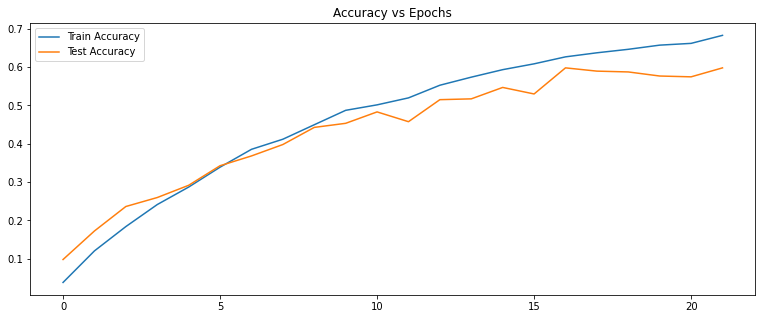

In [14]:
#Plot the graph to check training and testing accuracy over the period of time
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [15]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

In [16]:
#Test Accuracy
accuracy_score(y_test, predicted_classes)

0.597872340425532

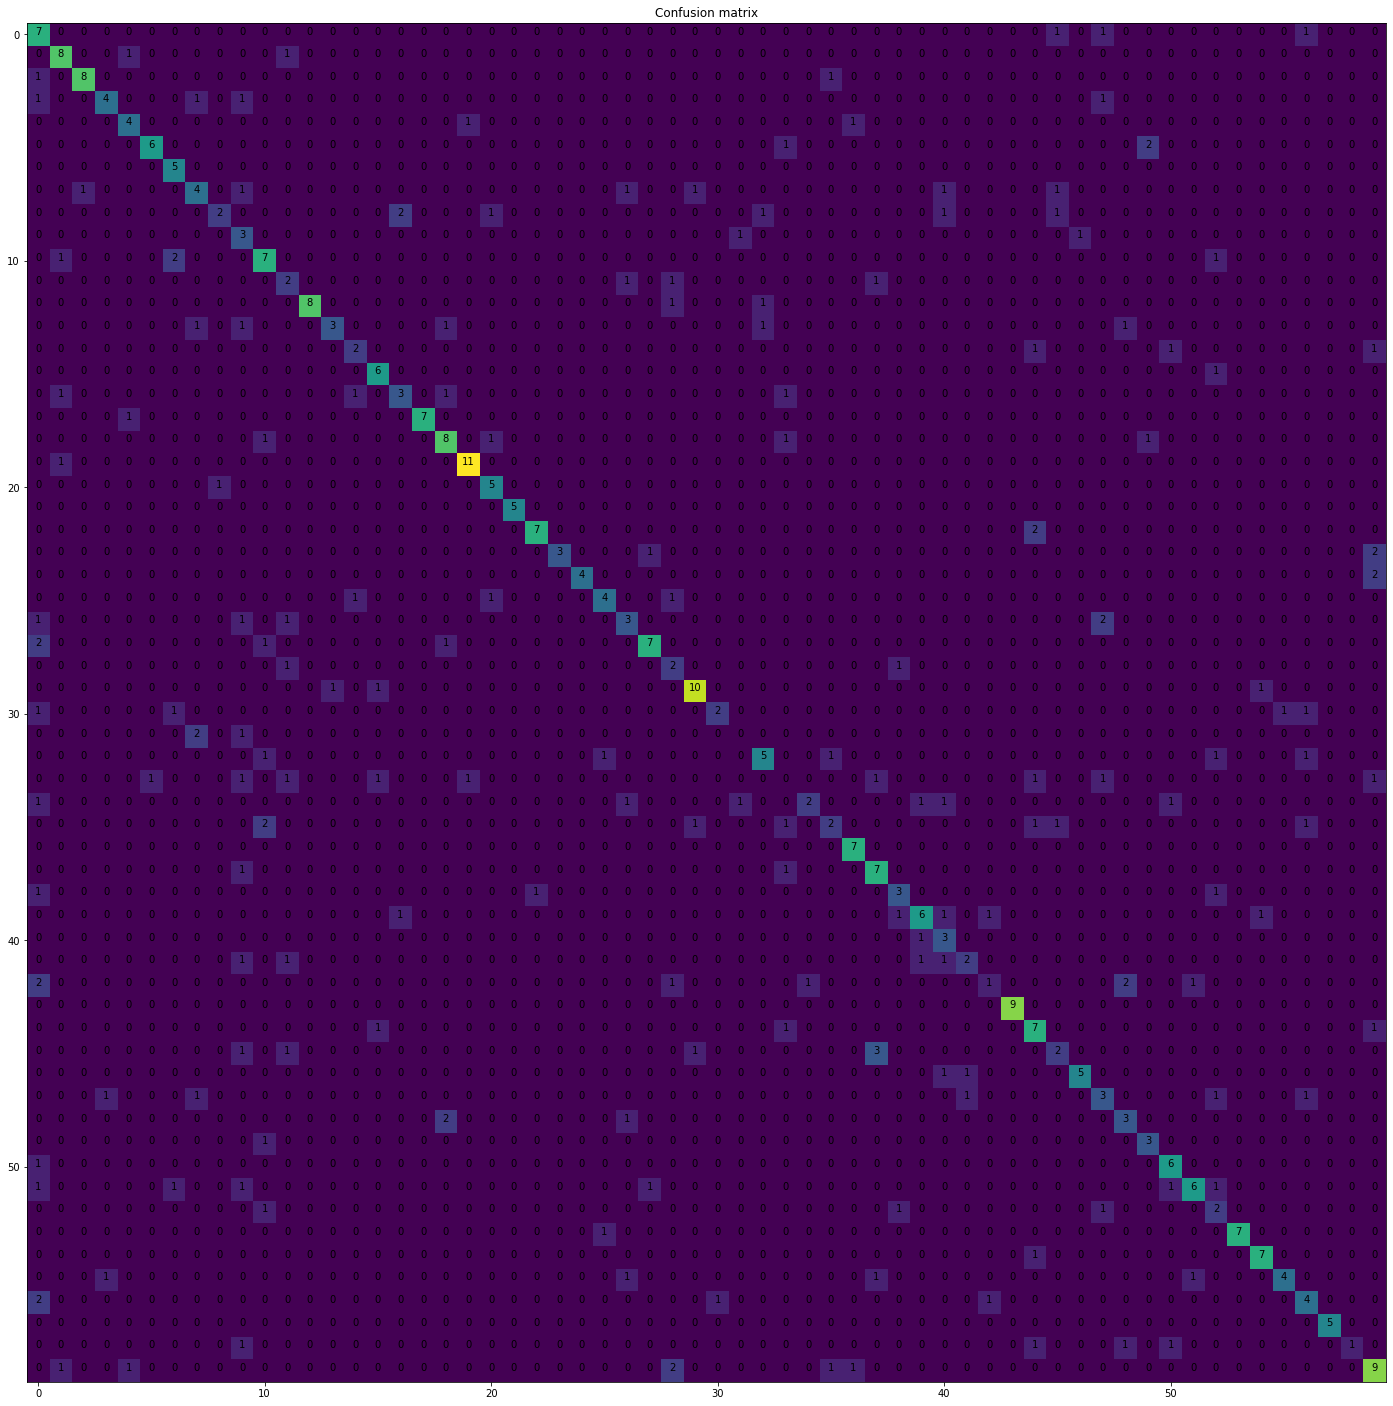

In [17]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

# Save the Model

In [18]:
model.save('CNN_Model.h5')